# Bikers on the Fremont bridge
Example adapted from the [Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

## Set up: Download (and load) data

In [1]:
# Download data(you can download it by uncommenting and runing this line of code)
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline

In [2]:
# Aggregate data to the daily level
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

# Data Prep: Adding Features

In [3]:
# Load weather data (downloaded from: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)
weather = pd.read_csv('data/weather.csv', index_col='DATE', parse_dates=True)

# Create dry_day column
weather['dry_day'] = (weather['PRCP'] == 0).astype(int)

In [4]:
# Join selected weather columns
daily = daily.join(weather[['PRCP', 'dry_day', 'TMIN', 'TMAX']])

(8, 17)

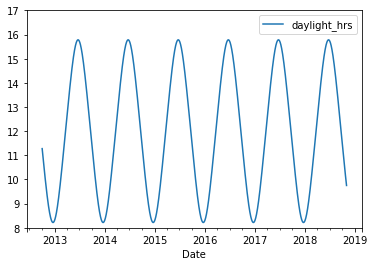

In [5]:
# Compute hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Feature Generation: Categorical Variable(s)

In [6]:
# Get dummy variables from categorical columns (alternative: sklearn OneHotEncoding)

# Abbreviated EDA

In [7]:
# What is the relationship between bikers and temperature?

In [8]:
# What is the relationship between bikers and date?

In [9]:
# What is the relationship between bikers and (min) temperature?

In [10]:
# What is the distribution of bikers on dry/wet days?

In [11]:
# How does the number of bikers vary by temperature and wet/dry?

# Modeling: KNN Regressor

In [12]:
# Split data into training and testing data

In [13]:
# Create a scaler and your classifier


# Define a pipeline that uses your scaler and classifier


# Define a grid to search through


# Perform a  grid search of your pipeline


In [14]:
# Compare prediction to (test) data


# Feature Generation: Polynomial Transformations

In [15]:
# Add a polynomial transformation to the pipeline


In [16]:
# Define a pipeline that includes the polynomial transformation


# Define a grid to search through (including the degree of polynomial)


# Perform a  grid search of your pipeline

In [17]:
# Visualize time trends


# Error assessment: find systematic errors

In [18]:
# Why are we getting this wrong?
# Assess error by day of the week


In [19]:
# Assess error by temperature and dry_day


In [20]:
# Assess error by precipitation


# Feature Selection: Select best features
As a form of dimensionality reduction, only select the top percentile features that have a certain threshold of variance.

In [21]:
# Create a percentile selector, add it to the pipeline
# (alternatives a K selectors, PCA, or others)


# Define a grid to search through (including the degree of polynomial AND percentile of best features)


In [22]:
# Fit the model